In [1]:
import json
import pickle

from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, lil_matrix
from scipy.linalg import norm

from sklearn.decomposition import TruncatedSVD

from matplotlib import pyplot as plt
from IPython.display import HTML, display
import pandas as pd
import numpy as np


In [2]:
with open("stored_variables/politics_tokens_text_tfidf.pickle", 'rb') as f:
    comment_tfidf = pickle.load(f)

In [3]:
with open("stored_variables/auth_sample_r_politics_authors.json", 'r') as f:
    comment_auths = json.load(f)

In [4]:
with open("stored_variables/user_subreddit_tf.pickle", "rb") as f:
    subreddit_tf = pickle.load(f)

In [5]:
with open("stored_variables/user_subreddit_df_mat.pickle", "rb") as f:
    subreddit_df_mat = pickle.load(f)

In [6]:
with open("stored_variables/user_subreddit_tf_auths.pickle", "rb") as f:
    author_names = pickle.load(f)

In [7]:
with open("stored_variables/user_subreddit_tf_subreddit_names.pickle", "rb") as f:
    subreddit_reverse_dict = pickle.load(f)

## Consolidate all comments by each user

In [13]:
author_reverse_dict = {author_names[i]:i for i in range(len(author_names))}

In [14]:
author_index_mapping = [author_reverse_dict[auth] for auth in comment_auths]

In [15]:
author_index_mapping[:5]

[12049, 496, 13502, 1594, 2957]

In [16]:
author_index_lists = [[] for i in comment_auths]

In [17]:
for i in range(len(author_index_mapping)):
    author_index_lists[author_index_mapping[i]].append(i)

In [18]:
author_index_lists[0]

[28117, 42390, 62493, 69447, 191770, 327109, 507092]

In [19]:
comment_tfidf[author_index_lists[0]]

<7x26903 sparse matrix of type '<class 'numpy.float64'>'
	with 67 stored elements in Compressed Sparse Row format>

In [20]:
comment_tfidf[author_index_lists[0]].sum(axis=0)

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [21]:
user_tfidf = lil_matrix((len(author_names), comment_tfidf.shape[1]))

In [22]:
for i in range(len(author_names)):
    user_tfidf[i] = comment_tfidf[author_index_lists[i]].sum(axis=0)

In [23]:
user_tfidf = csr_matrix(user_tfidf)

In [24]:
user_tfidf_norms = np.zeros(user_tfidf.shape[0])

In [25]:
for i in range(20):
    user_tfidf_norms[i*1000 : (i+1) * 1000] = norm(user_tfidf[i*1000 : (i+1) * 1000].toarray(), axis=1)

In [26]:
np.sum(user_tfidf_norms == 0)

128

In [27]:
user_tfidf_normalized = csr_matrix(user_tfidf / user_tfidf_norms[:, np.newaxis])

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/sparse/base.py:596: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


In [28]:
user_tfidf_normalized = np.nan_to_num(user_tfidf_normalized)

## Cosine similarities

In [58]:
subreddit_cosine_sims = np.zeros((user_tfidf.shape[0], user_tfidf.shape[0]))

In [59]:
for i in range(20):
    chunk1 = user_tfidf_normalized[i*1000 : (i+1)*1000, :]
    for j in range(20):
        chunk2 = user_tfidf_normalized[j*1000 : (j+1)*1000, :]
        subreddit_cosine_sims[i*1000 : (i+1)*1000, j*1000 : (j+1)*1000] = chunk1.dot(csc_matrix(chunk2.T)).toarray()


In [61]:
for i in range(user_tfidf.shape[0]):
    subreddit_cosine_sims[i,i] = 0

In [72]:
subreddit_cosine_sims[:10, :10]

array([[0.        , 0.16463552, 0.2135518 , 0.05702438, 0.        ,
        0.0815845 , 0.04397504, 0.11386743, 0.03653259, 0.14105598],
       [0.16463552, 0.        , 0.5444708 , 0.19721694, 0.07419665,
        0.07984482, 0.14125149, 0.29367859, 0.06767486, 0.30809811],
       [0.2135518 , 0.5444708 , 0.        , 0.20798209, 0.05643775,
        0.11743129, 0.13647504, 0.33295565, 0.09364797, 0.42706458],
       [0.05702438, 0.19721694, 0.20798209, 0.        , 0.01654098,
        0.05225555, 0.04829671, 0.14960268, 0.0132736 , 0.11736551],
       [0.        , 0.07419665, 0.05643775, 0.01654098, 0.        ,
        0.        , 0.00410197, 0.05280934, 0.        , 0.02531235],
       [0.0815845 , 0.07984482, 0.11743129, 0.05225555, 0.        ,
        0.        , 0.02766077, 0.07464161, 0.04695985, 0.06515754],
       [0.04397504, 0.14125149, 0.13647504, 0.04829671, 0.00410197,
        0.02766077, 0.        , 0.0636666 , 0.01076782, 0.08527921],
       [0.11386743, 0.29367859, 0.3329556

In [10]:
subreddit_cosine_sims = np.nan_to_num(subreddit_cosine_sims)

In [11]:
with open("stored_variables/user_comment_tfidf_cossims.pickle", "wb") as f:
    pickle.dump(subreddit_cosine_sims, f)
# with open("stored_variables/user_comment_tfidf_cossims.pickle", "rb") as f:
#     subreddit_cosine_sims = pickle.load(f)

In [29]:
most_similar_user = np.zeros(user_tfidf.shape[0], dtype = np.int32)

In [31]:
for i in range(user_tfidf.shape[0]):
    most_similar_user[i] = np.argsort(subreddit_cosine_sims[i])[-1]

In [32]:
most_similar_user[:10]

array([ 1594, 12937,  1067,  5493,  5774, 14796, 16133,  3723, 19221,
         491], dtype=int32)

In [36]:
[subreddit_cosine_sims[i, most_similar_user[i]] for i in range(10)]

[0.2791798324045479,
 0.7077331186147098,
 0.7707523931484866,
 0.3099528081241732,
 0.3097534030451072,
 0.25688051353715324,
 0.2786454548962458,
 0.49028885697468083,
 0.38321607638663047,
 0.5661493220806529]

## Check similarities by subreddits authors commented in

In [37]:
author_reverse_dict = {author_names[i]:i for i in range(len(author_names))}

In [38]:
num_sanders = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['sandersforpresident']]) for k in author_names}
num_trump = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['the_donald']]) for k in author_names}
num_clinton = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['hillaryclinton']]) for k in author_names}
num_politics = {k:(subreddit_tf[author_reverse_dict[k], subreddit_reverse_dict['politics']]) for k in author_names}


In [39]:
comment_threshold = 10

In [40]:
sanders_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_sanders[author_names[i]] >= comment_threshold]
trump_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_trump[author_names[i]] >= comment_threshold]
clinton_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_clinton[author_names[i]] >= comment_threshold]

In [41]:
none_user_indices = [i for i in range(subreddit_tf.shape[0]) if num_sanders[author_names[i]] == 0 and 
                     num_trump[author_names[i]] == 0 and
                     num_clinton[author_names[i]] == 0]

In [42]:
print(len(sanders_user_indices))
print(len(trump_user_indices))
print(len(clinton_user_indices))
print(len(none_user_indices))

1557
919
137
12958


In [43]:
print(len(set(sanders_user_indices).intersection(trump_user_indices)))
print(len(set(sanders_user_indices).intersection(clinton_user_indices)))
print(len(set(trump_user_indices).intersection(clinton_user_indices)))

206
73
18


In [44]:
np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,sanders_user_indices]) / \
(len(sanders_user_indices) * (len(sanders_user_indices)-1))

0.3225618491965682

In [45]:
np.sum(subreddit_cosine_sims[trump_user_indices, :][:,trump_user_indices]) / \
(len(trump_user_indices) * (len(trump_user_indices)-1))

0.2183588484732393

In [46]:
np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,clinton_user_indices]) / \
(len(clinton_user_indices) * (len(clinton_user_indices)-1))

0.4318208700627536

In [47]:
np.sum(subreddit_cosine_sims[none_user_indices, :][:,none_user_indices]) / \
(len(none_user_indices) * (len(none_user_indices)-1))

0.07587787892070122

In [48]:
np.sum(subreddit_cosine_sims) / (subreddit_cosine_sims.shape[0] * (subreddit_cosine_sims.shape[1] - 1))

0.10101289100058392

In [49]:
print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,trump_user_indices]) / \
((len(sanders_user_indices) * len(trump_user_indices)) - \
len(set(sanders_user_indices).intersection(trump_user_indices))))

print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,clinton_user_indices]) / \
((len(sanders_user_indices) * len(clinton_user_indices)) - \
len(set(sanders_user_indices).intersection(clinton_user_indices))))

print(np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,trump_user_indices]) / \
((len(clinton_user_indices) * len(trump_user_indices)) - \
len(set(clinton_user_indices).intersection(trump_user_indices))))

print()
print(np.sum(subreddit_cosine_sims[sanders_user_indices, :][:,none_user_indices]) / \
((len(sanders_user_indices) * len(none_user_indices))))
print(np.sum(subreddit_cosine_sims[trump_user_indices, :][:,none_user_indices]) / \
((len(trump_user_indices) * len(none_user_indices))))
print(np.sum(subreddit_cosine_sims[clinton_user_indices, :][:,none_user_indices]) / \
((len(clinton_user_indices) * len(none_user_indices))))

0.26312229825817285
0.37241445533761497
0.3026440316435393

0.15540457549571512
0.12701222145397267
0.17844877022384723


In [50]:
print(len(set(most_similar_user[sanders_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user[sanders_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user[sanders_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user[sanders_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user[sanders_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user[sanders_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user[trump_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user[trump_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user[trump_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user[trump_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user[trump_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user[trump_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))
print()
print(len(set(most_similar_user[clinton_user_indices]).intersection(sanders_user_indices)))
print(len(set(most_similar_user[clinton_user_indices]).intersection(sanders_user_indices))/len(sanders_user_indices))
print(len(set(most_similar_user[clinton_user_indices]).intersection(trump_user_indices)))
print(len(set(most_similar_user[clinton_user_indices]).intersection(trump_user_indices))/len(trump_user_indices))
print(len(set(most_similar_user[clinton_user_indices]).intersection(clinton_user_indices)))
print(len(set(most_similar_user[clinton_user_indices]).intersection(clinton_user_indices))/len(clinton_user_indices))



140
0.0899165061014772
58
0.06311207834602829
20
0.145985401459854

110
0.07064868336544637
63
0.06855277475516866
15
0.10948905109489052

42
0.02697495183044316
11
0.011969532100108813
12
0.08759124087591241


In [51]:
sanders_sanders_sims = []

for i in range(len(sanders_user_indices)):
    for j in range(i+1, len(sanders_user_indices)):
        sanders_sanders_sims.append(subreddit_cosine_sims[i,j])

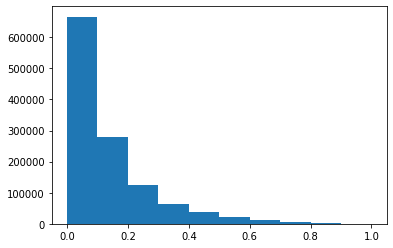

In [52]:
plt.hist(sanders_sanders_sims, range = (0, 1))
plt.show()

In [53]:
trump_trump_sims = []

for i in range(len(trump_user_indices)):
    for j in range(i+1, len(trump_user_indices)):
        trump_trump_sims.append(subreddit_cosine_sims[i,j])

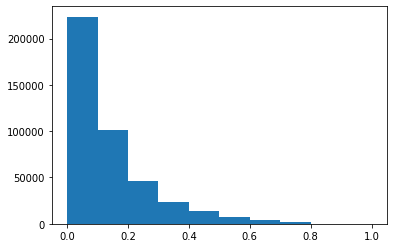

In [54]:
plt.hist(trump_trump_sims, range = (0,1))
plt.show()

In [55]:
clinton_clinton_sims = []

for i in range(len(clinton_user_indices)):
    for j in range(i+1, len(clinton_user_indices)):
        clinton_clinton_sims.append(subreddit_cosine_sims[i,j])

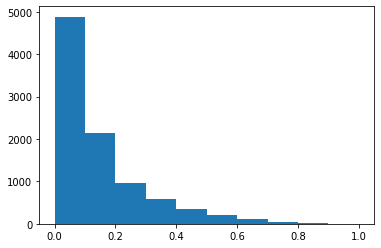

In [56]:
plt.hist(clinton_clinton_sims, range = (0,1))
plt.show()

# Error

should be 

`for i in clinton_user_indices`

not

`for i in range(len(clinton_user_indices))`